# Resources and credit:
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html
- Conceptual: https://medium.com/@hirotoschwert/digging-into-detectron-2-part-5-6e220d762f9
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [15]:
# install dependencies: 
!pip install pyyaml==5.1
#!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.7")
!gcc --version
# opencv is pre-installed on colab
exit(0)

1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [16]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
#assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


# Registration
*Register train, test, test_offshore, test_inshore datasets*

In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

In [7]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [8]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from detectron2.structures import BoxMode
# Register
for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])

AssertionError: ignored

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get('train')
test_metadata = MetadataCatalog.get('test')
train_w_val_metadata = MetadataCatalog.get('train/train_w_val')
validation_metadata = MetadataCatalog.get('train/validation')
toy_metadata = MetadataCatalog.get('train/toy')
test_offshore = MetadataCatalog.get('test_offshore')
train_offshore = MetadataCatalog.get('train_offshore')

# Model Loading

In [ ]:
# Quick copy/paste of models
# "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_23_2021_36000iters"
#"COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [10]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_50_FPN_3x_2_21_2021_train_val" # Replace w/ folder

/content/drive/MyDrive/SSDD


In [11]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # Replace w/ config
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship)
cfg.OUTPUT_DIR = model_name
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0029999.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # pg.23 of Zhang et al.
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.5 # pg.23 of Zhang et al.

## Initialize Trainer
*Hidden for brevity*

In [12]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[03/14 19:46:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Evaluation

## Prediction

### Custom Evaluator

Follows: https://cs230.stanford.edu/section/7/

In [13]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [14]:
def average_precision(correct, ground_truth): 
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)

  # Interpolate precision (replace each precision value with the maximum
  # precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
test = [True, True, False, False, False, True, True, False, False, True]
recall, precision, AP = average_precision(test, 5)
assert AP == 0.5285714285714286
assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
assert precision == [1.0, 
                    1.0, 
                    0.6666666666666666,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5,
                    0.5,
                    0.5]

In [15]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
    ):
      """
      Args:
          dataset_name (str): name of the dataset to be evaluated.
              It must have either the following corresponding metadata:

                  "json_file": the path to the COCO format annotation

              Or it must be in detectron2's standard dataset format
              so it can be converted to COCO format automatically.
          output_dir (str): an output directory to dump all
              results predicted on the dataset. The dump contains two files:

              1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                  a file that can be loaded with `torch.load` and
                  contains all the results in the format they are produced by the model.
              2. "coco_instances_results.json" a json file in COCO's result format.
      """
      self._cpu_device = torch.device("cpu")
      self.dataset_name = dataset_name
      self._metadata = MetadataCatalog.get(dataset_name)
      self._output_dir = output_dir
      if not hasattr(self._metadata, "json_file"):
        cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
        self._metadata.json_file = cache_path
        convert_to_coco_json(dataset_name, cache_path)

      json_file = PathManager.get_local_path(self._metadata.json_file)
      with contextlib.redirect_stdout(io.StringIO()):
          self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir,
                                     self.dataset_name + "_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    """
    iou_threshold = 0.5 # pg.23 of Zhang et al. 
    num_instances = 0
    num_pos = 0 # must be equal to GT
    gt_overlaps = []
    scores = []
    correct = []
    bad_images = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop overall all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

      num_pos += len(gt_boxes)

      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores best pred/gt iou
      _scores = torch.zeros(len(in_scores)) # stores iou for each score
      
      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)

          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]
          assert _gt_overlaps[j] == gt_ovr

          # record this iou coverage for score
          _scores[box_ind] =  overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1

      # update collectors
      _correct = (_scores >= iou_threshold).tolist()

      if _correct and sum(np.invert(_correct)) > 0:
        bad_images.append(prediction_dict)
      assert len(_correct) == len(_scores) == len(predictions)
      scores.append(in_scores)
      correct.append(_correct)
      gt_overlaps.append(_gt_overlaps)

    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)

    # stores TP/FP for each proposal box in all images 
    # (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2*(precision * recall) / (precision + recall)
    recalls, precisions, mAP = average_precision(correct, GT)

    plot =  {"recalls": recalls, "precisions": precisions}
    hist = {"gt_overlap" : gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }
    return copy.deepcopy(self._results), plot, hist, bad_images

### Training Predictions

In [ ]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('train/train_w_val', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
custEval = CustomEvaluator('train/train_w_val', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'train/train_w_val')

[03/01 17:24:00 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2994         |
|            |              |
[03/01 17:24:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/01 17:24:00 d2.data.common]: Serializing 5100 elements to byte tensors and concatenating them all ...
[03/01 17:24:00 d2.data.common]: Serialized dataset takes 0.86 MiB


In [ ]:
inference = inference_on_dataset(trainer.model,
                                 val_loader,
                                 custEval)

[03/01 17:24:02 d2.evaluation.evaluator]: Start inference on 5100 images
[03/01 17:24:05 d2.evaluation.evaluator]: Inference done 11/5100. 0.1974 s / img. ETA=0:17:15
[03/01 17:24:10 d2.evaluation.evaluator]: Inference done 36/5100. 0.1950 s / img. ETA=0:17:26
[03/01 17:24:15 d2.evaluation.evaluator]: Inference done 61/5100. 0.1941 s / img. ETA=0:17:24
[03/01 17:24:20 d2.evaluation.evaluator]: Inference done 85/5100. 0.1935 s / img. ETA=0:17:22
[03/01 17:24:25 d2.evaluation.evaluator]: Inference done 109/5100. 0.1929 s / img. ETA=0:17:27
[03/01 17:24:30 d2.evaluation.evaluator]: Inference done 133/5100. 0.1920 s / img. ETA=0:17:21
[03/01 17:24:35 d2.evaluation.evaluator]: Inference done 157/5100. 0.1913 s / img. ETA=0:17:18
[03/01 17:24:40 d2.evaluation.evaluator]: Inference done 181/5100. 0.1907 s / img. ETA=0:17:12
[03/01 17:24:46 d2.evaluation.evaluator]: Inference done 206/5100. 0.1901 s / img. ETA=0:17:05
[03/01 17:24:51 d2.evaluation.evaluator]: Inference done 229/5100. 0.1896 s 

In [ ]:
# Alternatively, load predictions directly from file into custEval instance
#temp = custEval._predictions
temp = torch.load(os.path.join(cfg.OUTPUT_DIR, "train_predictions.pth"))
custEval._predictions = temp
# evaluator._predictions = temp
# evaluator.evaluate()

In [ ]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.6789482498743928,
 'FN': 967,
 'FP': 950,
 'GT': 2994,
 'Pd': 0.6770207080828323,
 'Pf': 0.31911320120927106,
 'Pm': 0.3229792919171677,
 'TP': 2027,
 'mAP': 0.6170058064070733,
 'precision': 0.6808867987907289,
 'recall': 0.6770207080828323}

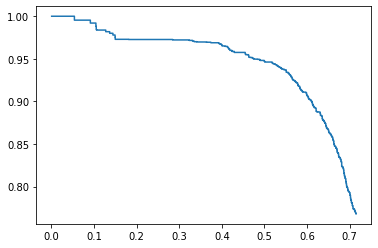

In [ ]:
# Precision Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.show()

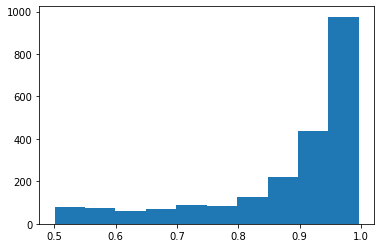

In [ ]:
# Scores of when gt_overlaps when (len(gt_box) != 0)
plt.hist(hist['scores'])
plt.show()

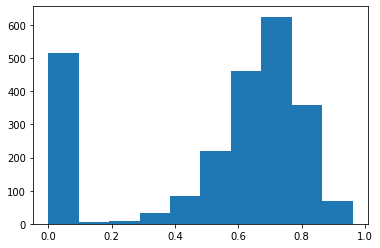

In [ ]:
# iou values for all matching instances (no threshold)
plt.hist(hist['gt_overlap'])
plt.show()

### Test Predictions

In [21]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
custEval = CustomEvaluator('test_inshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'test_inshore')

[03/14 20:04:17 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[03/14 20:04:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/14 20:04:17 d2.data.common]: Serializing 766 elements to byte tensors and concatenating them all ...
[03/14 20:04:17 d2.data.common]: Serialized dataset takes 0.14 MiB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
inference = inference_on_dataset(trainer.model,
                                 val_loader,
                                 custEval)

[03/14 20:04:20 d2.evaluation.evaluator]: Start inference on 766 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/14 20:04:24 d2.evaluation.evaluator]: Inference done 11/766. 0.0317 s / img. ETA=0:03:59
[03/14 20:04:29 d2.evaluation.evaluator]: Inference done 48/766. 0.0307 s / img. ETA=0:01:56
[03/14 20:04:34 d2.evaluation.evaluator]: Inference done 83/766. 0.0310 s / img. ETA=0:01:47
[03/14 20:04:39 d2.evaluation.evaluator]: Inference done 121/766. 0.0308 s / img. ETA=0:01:36
[03/14 20:04:44 d2.evaluation.evaluator]: Inference done 164/766. 0.0309 s / img. ETA=0:01:24
[03/14 20:04:50 d2.evaluation.evaluator]: Inference done 205/766. 0.0308 s / img. ETA=0:01:17
[03/14 20:04:55 d2.evaluation.evaluator]: Inference done 246/766. 0.0309 s / img. ETA=0:01:10
[03/14 20:05:00 d2.evaluation.evaluator]: Inference done 287/766. 0.0308 s / img. ETA=0:01:03
[03/14 20:05:05 d2.evaluation.evaluator]: Inference done 329/766. 0.0307 s / img. ETA=0:00:57
[03/14 20:05:10 d2.evaluation.evaluator]: Inference done 372/766. 0.0307 s / img. ETA=0:00:51
[03/14 20:05:15 d2.evaluation.evaluator]: Inference done 411/76

In [ ]:
# Alternatively, load predictions directly from file into custEval instance
#temp = custEval._predictions
temp = torch.load(os.path.join(cfg.OUTPUT_DIR, "test_predictions.pth"))
custEval._predictions = temp
# evaluator._predictions = temp
# evaluator.evaluate()

In [23]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.4827160493827161,
 'FN': 492,
 'FP': 346,
 'GT': 883,
 'Pd': 0.44280860702151753,
 'Pf': 0.4694708276797829,
 'Pm': 0.5571913929784824,
 'TP': 391,
 'mAP': 0.3622009603483481,
 'precision': 0.5305291723202171,
 'recall': 0.44280860702151753}

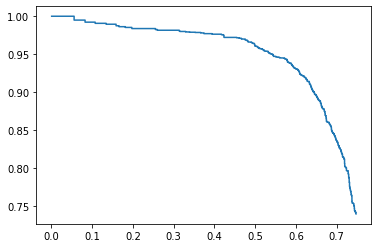

In [ ]:
# Precision Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.show()

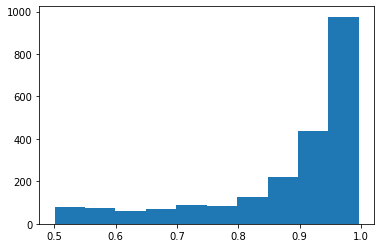

In [ ]:
# Scores of when gt_overlaps when (len(gt_box) != 0)
plt.hist(hist['scores'])
plt.show()

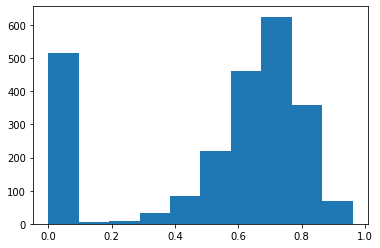

In [ ]:
# iou values for all matching instances (no threshold)
plt.hist(hist['gt_overlap'])
plt.show()

### Visualization
*Output images where predictions are wrong for error analysis*

In [ ]:
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts = get_dict("train/train_w_val")
bad_images_ind = [i['image_id'] for i in bad_images]
# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['image_id'] in bad_images_ind:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  from detectron2.utils.visualizer import Visualizer
  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  if predFlag:
    outputs = predictor(im)  
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  image = out.get_image()[:, :, ::-1]
  return image

In [ ]:
from cv2 import hconcat
num_samples = 300
os.makedirs(model_name + "/predImages", exist_ok=True) # Make a directory for output images
#random.seed(1)
for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True) # Predictions
  image2 = printImage(d, test_metadata, False) # Ground truth
  image3 = hconcat([image1, image2])
  #cv2_imshow(image3)
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)